# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, './venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

# Instantiate a brand new model

In [2]:
# tokenizer
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(size = 4096) # size options are 128, 256, 512, 1024, 2048 & 4096

# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
cfg.vocab_len = tokenizer.vocab_len
tcfg = TrainConfig()
print(cfg, '\n\n', tcfg)

# model modules
from model import customGPT
model = customGPT(cfg).to(cfg.device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters\n')
print(model)

ModelConfig(dim=64, vocab_len=4099, device='cpu', num_layers=12, second_resid_norm=False, mlp_hidden_mult=1, mlp_bias=True, mlp_nonlinearity='GeLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=16, theta=10000, max_seq_len=256, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 TrainConfig(weight_decay=0.02, batch_size=32, max_iters=500, eval_interval=50, eval_samples=3, checkpoint_interval=None, lr_max=0.1, lr_min=1e-05, warmup_iters=50, final_flat_iters=200, anneal_type='cos', num_restarts=2, T_mult=2)
489.024 K parameters

customGPT(
  (token_embedder): Embedding(4099, 64)
  (layers): ModuleList(
    (0-11): 12 x ResidualLayer(
      (pre_attn_norm): Norm()
      (attn): MQSA(
        (Wq): Linear(in_features=64, out_features=32, bias=False)
        (Wk): Linear(in_features=64, out_features=16, bias=False)
        (Wv): Linear(in_features=64, out_features=16, bias=False)
        (Wo): Linear(in_features=32, out_f

# Training

In [3]:
import torch
from tools import get_data_loader
from train import scheduler_lambda, train

optimizer = torch.optim.AdamW(model.parameters(), lr = tcfg.lr_max, weight_decay = tcfg.weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

train_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='train')
test_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='validation')

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


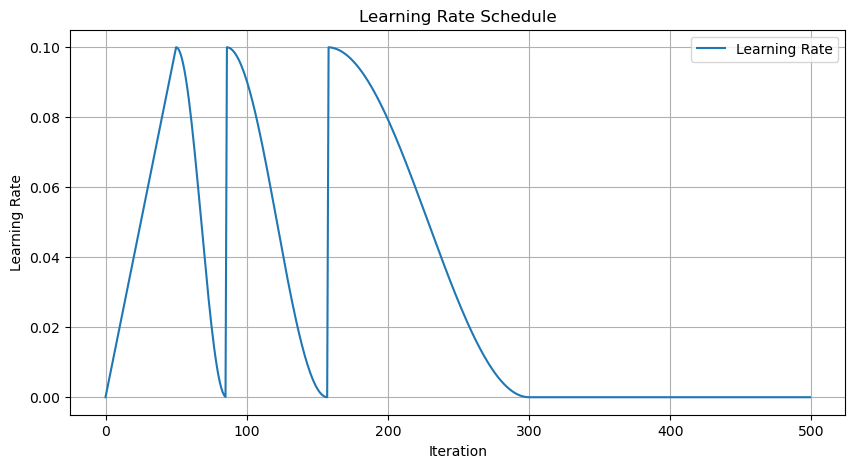

In [4]:
if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
model, optimizer, log_data = train(
    model, 
    tokenizer, 
    cfg, 
    optimizer,
    scheduler,
    tcfg, 
    train_data_loader,
    test_data_loader,
    #log_data: list = None, 
    #detect_anomoly = False # use if you're getting crazy errors about a the gradient being broken
)

  0%|                            | 1/500 [00:03<28:17,  3.40s/it]

step 0000: lr 0.000001, train loss 64.2834, val loss 64.1451, ppl 7276087099064977201668554752, time elapsed: 1.06 seconds


 10%|██▊                        | 51/500 [00:44<14:36,  1.95s/it]

step 0050: lr 0.010000, train loss 6.8233, val loss 6.8758, ppl 970, time elapsed: 40.31 seconds


 20%|█████▎                    | 101/500 [01:28<10:23,  1.56s/it]

step 0100: lr 0.009045, train loss 5.2269, val loss 5.2277, ppl 187, time elapsed: 85.79 seconds


 30%|███████▊                  | 151/500 [02:09<08:45,  1.51s/it]

step 0150: lr 0.000246, train loss 4.8037, val loss 4.8741, ppl 131, time elapsed: 127.05 seconds


 40%|██████████▍               | 201/500 [02:49<07:21,  1.48s/it]

step 0200: lr 0.007939, train loss 4.2771, val loss 4.3162, ppl 75, time elapsed: 166.69 seconds


 50%|█████████████             | 251/500 [03:28<06:03,  1.46s/it]

step 0250: lr 0.002731, train loss 3.9524, val loss 3.9575, ppl 52, time elapsed: 206.30 seconds


 60%|███████████████▋          | 301/500 [04:07<04:52,  1.47s/it]

step 0300: lr 0.000001, train loss 3.8525, val loss 3.8229, ppl 46, time elapsed: 245.32 seconds


 70%|██████████████████▎       | 351/500 [04:47<03:42,  1.50s/it]

step 0350: lr 0.000001, train loss 3.7953, val loss 3.9554, ppl 52, time elapsed: 284.88 seconds


 80%|████████████████████▊     | 401/500 [05:29<02:34,  1.56s/it]

step 0400: lr 0.000001, train loss 3.9024, val loss 3.8633, ppl 48, time elapsed: 327.25 seconds


 90%|███████████████████████▍  | 451/500 [06:11<01:11,  1.46s/it]

step 0450: lr 0.000001, train loss 3.8526, val loss 3.8802, ppl 48, time elapsed: 368.70 seconds


100%|██████████████████████████| 500/500 [06:49<00:00,  1.22it/s]

step 0499: lr 0.000001, train loss 3.8879, val loss 3.8579, ppl 47, time elapsed: 407.11 seconds


# inference test before you decide to save it
if `tcfg.checkpoint_interval != None` then checkpoints have already been saved

In [6]:
from inference import generate
prompt = "Once upon a time"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #max_gen_len = 512,
    temperature = 0.7,
    #memory_saver_div = 8,
    #top_p = 0.9,
    #top_k = 32,
)
model.train()
print(output)

Once upon a time, there was a little girl named said, "ime, said, "I  by named in a big, but he lover named to play Pt, the very, in a big wanted to play named They in the, "I , the on the park with the is you cared was a. Sherraid, "No, the saw the, "I  big was oy. They wasked  she n and star.
They had and said, "Whee the played ve the park. They a oy. She not very was othe very girl o play was was so park. The and of he ved l. The with his a very happy name ent saw ther. He ound fun. The was could not littles oy it up d


# Saving your final model
you DO still need to do this even if you had been saving checkpoints; the final state has not yet been saved

In [7]:
from tools import save_model
save_model(model, cfg, tcfg, log_data)